In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch
# import minerl
from tqdm import tqdm
import random

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from collections import defaultdict
import coordconv

import collections

from ZerO import init_ZerO
from networks import SkippableLayerNorm
from lion_pytorch import Lion
from mdn import *
from DotEnvs import *
from utilities import soft_update
from basic_dqn import DQN_Policy

In [4]:
class EnvSamplingWrapper:
    def __init__(self, env):
        self.env = env
        self.obs = env.reset()
        self.step_count = 0
        self.total_reward = 0
    
    def sample(self, count, policy):
        tuples = []
        rewards = []
        for i in range(count):
            self.step_count += 1
            action = policy(self.obs)
            observation, reward, done, info = env.step(action)
            tuples.append((self.obs, action, reward, observation, done))
            self.obs = observation
            self.total_reward += reward
            if done:
                self.obs = env.reset()
                rewards.append((self.total_reward, self.step_count))
                self.total_reward = 0
        
        return tuples, rewards


def prod(x):
    total = 1
    for i in x:
        total *= i
    return total




    


In [5]:
"""
From https://github.com/rlcode/per/blob/master/SumTree.py
"""
import numpy


# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros(2 * capacity - 1)
        self.data = numpy.zeros(capacity, dtype=object)
        self.n_samples = numpy.zeros(capacity)
        self.n_entries = 0
        self.write = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]
    
    def data_idx(self, idx):
        return (idx + self.capacity + 1) % self.capacity
    
    def tree_idx(self, d_idx):
        return d_idx + self.capacity - 1

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1
        return idx

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        self.n_samples[dataIdx] += 1

        return (idx, self.tree[idx], self.data[dataIdx])
    
    def get_at(self, idx):
        return (idx, self.tree[idx], self.data[self.data_idx(idx)])

In [6]:
# replay buffer. Store (s, a, r, s_n, d) tuples
class PrioritizedReplayBuffer:
    def __init__(self, max_size=1000000, epsilon=0.00001):
        self.tree = SumTree(max_size)
        self.epsilon = epsilon
    
    def add(self, s, a, r, s_n, d):
        self.tree.add(1, (s, a, r, s_n, d))
    
    def sample_batch(self, batch_size):
        batch = []
        chunk = self.tree.total() / batch_size
        for i in range(batch_size):
            item = self.tree.get(random.random() * chunk + i * chunk)
            batch.append(item)
        return batch
    
    def add_all(self, sarsd):
        for i in sarsd:
            buffer.add(*i)
    
    def update(self, idx, p):
        self.tree.update(idx, p + self.epsilon)

In [7]:
def sample_training_batch(buffer, batch_size):
    batch = buffer.sample_batch(batch_size)
    s = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    a = np.zeros((batch_size, 1), dtype='int64')
    r = np.zeros((batch_size, 1), dtype='float32')
    s_n = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    d = np.zeros((batch_size, 1), dtype='float32')

    
    for i, data in enumerate(batch):
        x = data[2]
        s[i] = x[0]
        a[i] = x[1]
        r[i] = x[2]
        s_n[i] = x[3]
        d[i] = x[4]
    
    s = torch.from_numpy(s).permute((0, 3, 1, 2)).cuda() / 255
    s_n = torch.from_numpy(s_n).permute((0, 3, 1, 2)).cuda() / 255
    a = torch.from_numpy(a).cuda()
    r = torch.from_numpy(r).cuda()
    d = torch.from_numpy(d).cuda()
    
    return s, a, r, s_n, d, batch

In [8]:
STATS = defaultdict(list)
env = SparseDotEnv()
# env = DotEnv()
env_wrapper = EnvSamplingWrapper(env)

In [9]:
buffer = PrioritizedReplayBuffer()
# initialize the buffer:
sarsd, rew = env_wrapper.sample(10000, lambda x: env.action_space.sample())
buffer.add_all(sarsd)

In [10]:
class DistDQN_Net(nn.Module):
    def __init__(self, input_size, action_size, zero=True):
        super().__init__()
#         print(input_size)
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.GELU(),
            nn.Linear(16, 16),
            nn.GELU(),
            MDN(16, action_size, 1),
        )
    
    def forward(self, x):
#         print(x.shape)
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.net(x)
        return x

In [11]:
def sample_action(outputs, fraction):
    pi, sigma, mu = outputs
    shape = mu.shape
    
    offset_mean = pi * (sigma * fraction + mu)
    return offset_mean.view(shape[:-1])

In [52]:
def dqn_policy(model, obs):
    # scale the obs, change to model shape
    image = torch.from_numpy(to_batch_shape(obs)).permute((0, 3, 1, 2)).cuda() / 255
    with torch.no_grad():
        outputs = model(image)
        action = torch.argmax(sample_action(outputs, 1)).item()
    
    return action

In [53]:
class DQN_Policy:
    def __init__(self, model, epsilon, sampler):
        self.model = model
        self.epsilon = epsilon
        self.sampler = sampler
    
    def __call__(self, obs):
        if random.random() < self.epsilon:
            return self.sampler()
        return dqn_policy(self.model, obs)

In [92]:

def gnll_loss_individual(pi, sigma, mu, target):
    gm = distribution(pi, sigma, mu)
    print(gm)
#     print(target)
#     print(mu)
    log_likelihood = gm.log_prob(target.view(-1))
#     log_likelihood = gm.log_prob(target)
#     print(log_likelihood)
#     print(gm.batch_shape)
    return torch.log(torch.exp(-log_likelihood) + 1)


In [93]:
mix = 2
pi = torch.ones((32, mix))
sigma = torch.ones((32, mix))
mu = torch.ones((32, mix))

target = torch.arange(0, 3.2, step=0.1).view(32)
gnll_loss_individual(pi, sigma, mu, target)

MixtureSameFamily(
  Categorical(probs: torch.Size([32, 2]), logits: torch.Size([32, 2])),
  Normal(loc: torch.Size([32, 2]), scale: torch.Size([32, 2])))


tensor([1.6356, 1.5599, 1.4933, 1.4357, 1.3865, 1.3456, 1.3125, 1.2870, 1.2690,
        1.2582, 1.2547, 1.2582, 1.2690, 1.2870, 1.3125, 1.3456, 1.3865, 1.4357,
        1.4933, 1.5599, 1.6356, 1.7210, 1.8164, 1.9221, 2.0385, 2.1657, 2.3041,
        2.4538, 2.6149, 2.7875, 2.9715, 3.1670])

In [211]:
bs = 7
step = 0.2
mix = 2
pi = F.softmax(torch.ones((bs, mix)))
sigma = torch.ones((bs, mix))
mu = torch.ones((bs, mix))

target = torch.arange(0, bs * step * mix, step=step).view(bs, 1, mix)

(pi.reshape(-1, 2, 1) * target).shape
pi_rs = pi.reshape(-1, 2, 1)

mu_rs = mu.reshape(-1, 2, 1)
s_rs = sigma.reshape(-1, 2, 1)

(pi.reshape(-1, 2, 1) * target * target).shape
D.Normal(mu_rs, s_rs).log_prob(pi_rs).shape, pi_rs.shape
(pi.reshape(-1, 2, 1) + target)

tensor([[[0.5000, 0.7000],
         [0.5000, 0.7000]],

        [[0.9000, 1.1000],
         [0.9000, 1.1000]],

        [[1.3000, 1.5000],
         [1.3000, 1.5000]],

        [[1.7000, 1.9000],
         [1.7000, 1.9000]],

        [[2.1000, 2.3000],
         [2.1000, 2.3000]],

        [[2.5000, 2.7000],
         [2.5000, 2.7000]],

        [[2.9000, 3.1000],
         [2.9000, 3.1000]]])

In [212]:
def gather_actions(outputs, actions):
    pi, sigma, mu = outputs
    batch_size = pi.shape[0]
    gathered = [torch.gather(x, 1, actions.view(-1, 1, 1)).view(batch_size, -1) for x in outputs]
    return gathered

In [213]:
def pairwise(a, b):
    pi, si, mi = a
    pj, sj, mj = b
    bs = pi.shape[0]
    
    # pi*pj*N(mi;mj,si^2+sj^2)
    # make the normals
    N = D.Normal(mj.reshape(bs, 1, -1), torch.sqrt(si.reshape(bs, -1, 1) ** 2 + sj.reshape(bs, 1, -1) **2))
    return torch.sum(pi.reshape(bs, -1, 1) * pj.reshape(bs, 1, -1) * torch.exp(N.log_prob(mi.reshape(bs, -1, 1))), (1, 2))
    

In [214]:
t = (pi, sigma, mu)
pairwise(t, t)

tensor([0.2821, 0.2821, 0.2821, 0.2821, 0.2821, 0.2821, 0.2821])

In [215]:
def jtd(output, target):
    pi, si, mi = output
    pj, sj, mj = target
    
    # pi*pj*N(mi;mj,si^2+sj^2)
    # make the pairwise comparisions
    return pairwise(output, output) + pairwise(target, target) - 2 * pairwise(output, target)

In [237]:
jtd(t, (pi, sigma, mu))

tensor([0., 0., 0., 0., 0., 0., 0.])

In [221]:
def train_batch(model, target, buffer, optimizer, curiosity=None):
    # get the inputs
    
    # sample from the buffer and preprocess next qs
    s, a, r, s_n, d, batch = sample_training_batch(buffer, 32)
    
    # get the next qs
    with torch.no_grad():
        # I need to train to the scaled and transformed reward for the selected action, not just the mean
        pi, sigma, mu = target(s_n)
        outputs = [pi, sigma, mu]
        base_dist = distribution(pi, sigma, mu)
#         print(base_dist.mean)
        mq_n, a_n = torch.max(base_dist.mean, 1)
        pi, sigma, mu = gather_actions(outputs, a_n)
#         print(q_n_dist)
        
        gamma = 0.99
        
        # get scaled and transformed targets
        # done case: target of r with sd 1?
#         print(d.shape, r.shape, sigma.shape, (sigma * gamma).shape)
        target_gm = (pi, sigma * gamma * (1 - d) + d, mu * gamma * (1 - d) + r)

    
    if curiosity:
        targets += curiosity.get_results(s)

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    
    # forward + backward + optimize
    outputs = model(s)
    pi, sigma, mu = outputs
    shape = pi.shape[:-1]
# #     print(shape)
#     outputs = [torch.gather(x.view(shape), 1, a) for x in outputs]
    actual_gm = (*gather_actions(outputs, a),)
    

    individual_loss = jtd(actual_gm, target_gm)
#     print(individual_loss)
    loss = torch.mean(individual_loss)

    loss.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    for i, l in enumerate(individual_loss.detach().reshape(-1).tolist()):
#         print(batch[i])
        tree_idx = batch[i][0]
        tree = buffer.tree
        buffer.update(tree_idx, l)
        prev = tree.get_at(tree.tree_idx(tree.data_idx(tree_idx - 1)))
        # skip the wrap around states and terminal states
        if not prev[2] or prev[2][4]:
            continue
#         print(prev[0], prev[1], l)
        buffer.update(prev[0], prev[1] + l)
        
    return loss.detach().item()

In [222]:
model = DistDQN_Net(prod(env.observation_space.shape), env.action_space.n)
model.cuda()
target = DistDQN_Net(prod(env.observation_space.shape), env.action_space.n)
target.cuda()
target.eval()
soft_update(target, model, 1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
# optimizer = Lion(model.parameters(), lr=0.00001)

In [223]:
train_batch(model, target, buffer, optimizer, None)

0.0061444127932190895

In [224]:
def dqn_loop(model, target, env_wrapper, buffer, optimizer, curiosity, steps, STATS):
    running_loss = None
    running_rew = 0
    
    next_exploration = 0.95
    with tqdm(range(steps), unit="batch") as t:
        for i in t:
            
            if i % 2500 == 0:
                policy = DQN_Policy(model, next_exploration, env_wrapper.env.action_space.sample)
                next_exploration -= 0.05
                next_exploration = max(next_exploration, 0.05)
            
            sarsd, rew = env_wrapper.sample(1, policy)
            buffer.add_all(sarsd)
            STATS['returns'].extend(rew)
            for r in rew:
                running_rew = running_rew * 0.99 + r[0] * 0.01
            
            if (i + 1) % 4 != 0:
                continue

            loss = train_batch(model, target, buffer, optimizer, curiosity)
            STATS["loss"].append(loss)

#             if i % 10000 == 0:
#                 soft_update(target, model, 1.0)
            soft_update(target, model, 0.001)
            if running_loss is None:
                running_loss = loss
            running_loss = running_loss * 0.999 + loss * 0.001
            if (i + 1) % 100 == 0:  # print every N mini-batches
                string = 'loss: %.8f, rew: %.8f' % (
                    running_loss, running_rew
                )
                t.set_postfix_str(string)

In [225]:
model = DistDQN_Net(prod(env.observation_space.shape), env.action_space.n)
model.cuda()
target = DistDQN_Net(prod(env.observation_space.shape), env.action_space.n)
target.cuda()
target.eval()
soft_update(target, model, 1.0)
# optimizer = optim.AdamW(model.parameters(), lr=0.0001)
optimizer = Lion(model.parameters(), lr=0.00001)

In [226]:
STATS = defaultdict(list)

In [227]:
env = SparseDotEnv()
# env = DotEnv()
env_wrapper = EnvSamplingWrapper(env)

In [228]:
buffer = PrioritizedReplayBuffer()
# initialize the buffer:
sarsd, rew = env_wrapper.sample(10000, lambda x: env.action_space.sample())
buffer.add_all(sarsd)

In [ ]:
dqn_loop(model, target, env_wrapper, buffer, optimizer, None, 100000, STATS)

 63%|███████████▉       | 62841/100000 [02:56<01:34, 394.31batch/s, loss: 0.00166675, rew: 0.08105873]

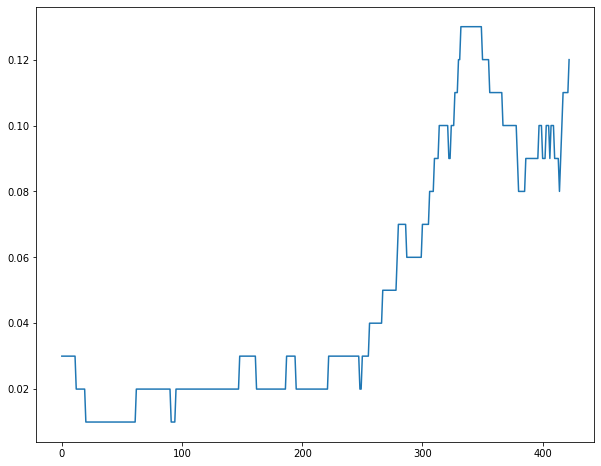

In [230]:
plt.plot(np.convolve(np.asarray([x[0] for x in STATS['returns']]), np.ones((100,)) / 100, mode='valid'))

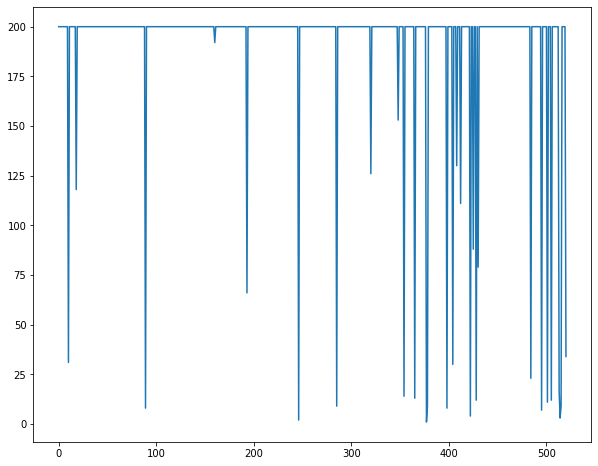

In [231]:
plt.plot(np.convolve(np.convolve(np.asarray([x[1] for x in STATS['returns']]), np.asarray([1, -1]), mode='valid'), np.ones((1,)) / 1, mode='valid'))

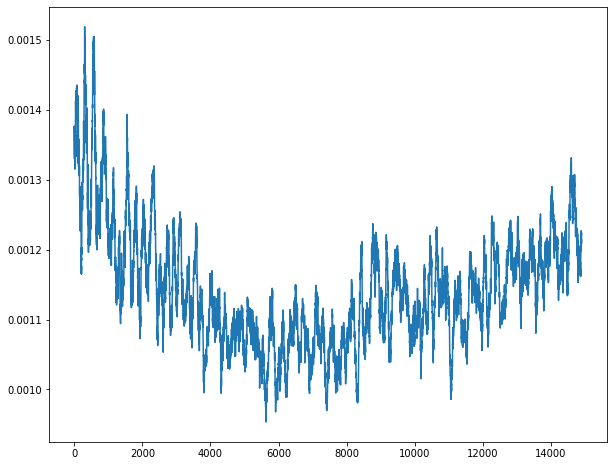

In [232]:
plt.plot(np.convolve(np.asarray(STATS['loss']), np.ones((100,)) / 100, mode='valid')[10000:])

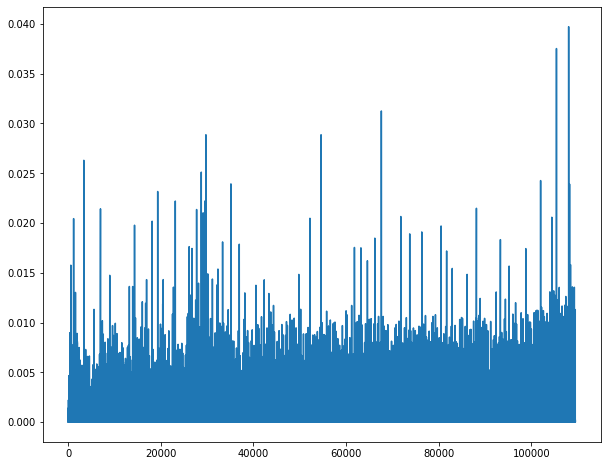

In [233]:
plt.plot(buffer.tree.tree[buffer.tree.tree_idx(0):buffer.tree.tree_idx(buffer.tree.n_entries)-500])

In [234]:
# evaluate the model on all possible states, then display the return
sum_obs = np.zeros((64, 64))

# generate all possible states, and calculate their return
states = []
for i in range(64):
    for j in range(64):
        observation = np.zeros((64, 64, 3), dtype=np.uint8)
        observation[i:i+2, j:j+2] = np.array([255, 255, 255])
        image = torch.from_numpy(to_batch_shape(observation)).permute((0, 3, 1, 2)).cuda() / 255
        with torch.no_grad():
            outputs = sample_action(model(image), 0)
            q_n, a_n = torch.max(outputs, 1)
        sum_obs[i, j] = q_n.item()

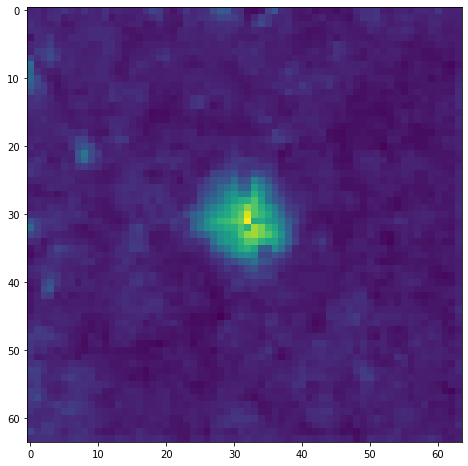

In [235]:
plt.imshow(sum_obs)

In [236]:
sum_obs.max(), sum_obs.min(), sum_obs.mean()

(0.6784588694572449, 0.0909738764166832, 0.1523830688893213)